# $\vert 0 \rangle$ state decaying


In [1]:
from pprint import pprint
from datetime import date
from pathlib import Path

from experiments.utils import get_IBM_backend, pickle_load, pickle_dump
from experiments.waiting_duration import EvaluateDelay
from experiments.waiting_duration.benchmarks import prepare_singleBench
from experiments.waiting_duration import execute_bench

from qiskit.visualization import plot_histogram

In [2]:
# user input
backend_name = "ibmq_bogota"
nseed = 5
date = "2020-11-20"
initial_layout = [0]

In [3]:
# define backends
backend = get_IBM_backend(backend_name)
simulator = get_IBM_backend("ibmq_qasm_simulator")

# type of experiments 
exp_type = "single_qubit"
initial_state="zero_state"

/Users/Yasuhiro/.local/share/virtualenvs/experiments-VWP9UmJy/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Send job

In [4]:
def _save_jobid_path(date, duration_label, initial_state=None, initial_layout=None):
    root = Path(".")
    file_name = date
    if initial_state: 
        file_name += "_"+ initial_state
    
    if initial_layout: 
        file_name += "_"+ duration_label +"_"+ str(initial_layout) +".pickle" 
    else: 
        file_name += "_"+ duration_label +".pickle"
    
    path = root /"job_id" / file_name
        
    return path

In [5]:
# max(dt) = 1E6
jobid_path_e6 = _save_jobid_path(date, "e6", initial_state, initial_layout)
delay_duration_e6 = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000]

In [6]:
qc = prepare_singleBench(initial_state, "e6")
execute_bench(
            qc, 
            backend=backend, 
            simulator=simulator, 
            initial_layout=initial_layout, 
            save_path = jobid_path_e6,
            delay_duration_list=delay_duration_e6,
            nseed=nseed, 
)

In [7]:
# max(dt) = 1E5
# delay dulation label
jobid_path_e5 = _save_jobid_path(date, "e5", initial_state, initial_layout)
delay_duration_e5 = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000]

In [8]:
qc = prepare_singleBench(initial_state, "e5")
execute_bench(
            qc, 
            backend=backend, 
            simulator=simulator, 
            initial_layout=initial_layout, 
            save_path = jobid_path_e5,
            delay_duration_list=delay_duration_e5,
            nseed=nseed, 
)

In [9]:
# max(dt) = 1E4
# delay dulation label
jobid_path_e4 = _save_jobid_path(date, "e4", initial_state, initial_layout)
delay_duration_e4 = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]

In [11]:
qc = prepare_singleBench(initial_state, "e4")
execute_bench(
            qc, 
            backend=backend, 
            simulator=simulator, 
            initial_layout=initial_layout, 
            save_path = jobid_path_e4,
            delay_duration_list=delay_duration_e4,
            nseed=nseed, 
)

## calculate results

In [12]:
def calculate_results(delay_dutation, job_id_path, save_data_path):
    exp_data = pickle_load(job_id_path)
    job_sim = simulator.retrieve_job(exp_data["simulator"]["job_id"])
    job_delay_before = [backend.retrieve_job(job_id) for job_id in exp_data["delay_before"]["job_id"]]
    job_delay_after = [backend.retrieve_job(job_id) for job_id in exp_data["delay_after"]["job_id"]]
    delay_duration_list = exp_data["delay_duration_list"]

    eval_delay = EvaluateDelay(job_sim, job_delay_before, job_delay_after, delay_duration_list, nseed=nseed, initial_layout=[0])
    counts_before_list_list, counts_after_list_list = eval_delay.evaluate() # return [[seed1 counts_dict], [seed2 counts_dict], ... ]
    
    # calculate mean and sem (standard error mean) of counts
    counts_before_list_mean, counts_before_list_sem = eval_delay.stat(counts_before_list_list)
    counts_after_list_mean, counts_after_list_sem = eval_delay.stat(counts_after_list_list)
    
    # calculate jsd
    before_jsd_all, before_jsd_mean, before_jsd_sem = eval_delay.js_divergence(counts_before_list_list)
    after_jsd_all, after_jsd_mean, after_jsd_sem = eval_delay.js_divergence(counts_after_list_list)
    
    save_data = {
            "before_op": {
                "counts_list_all": counts_before_list_list, 
                "counts_list_mean": counts_before_list_mean, 
                "counts_list_sem": counts_before_list_sem, 
                "jsd_all": before_jsd_all, 
                "jsd_mean": before_jsd_mean, 
                "jsd_sem": before_jsd_sem, 
                },  
            "after_op": {
                "counts_list_all": counts_after_list_list, 
                "counts_list_mean": counts_after_list_mean, 
                "counts_list_sem": counts_after_list_sem, 
                "jsd_all": after_jsd_all, 
                "jsd_mean": after_jsd_mean, 
                "jsd_sem": after_jsd_sem,
                }, 
            "delay_duration": delay_dutation,
            "nseed": nseed
            }
    pickle_dump(save_data, save_data_path)
    return save_data 

In [13]:
def _save_data_path(date, duration_label, initial_state=None, initial_layout=None):
    root = Path(".")
    file_name = date
    if initial_state: 
        file_name += "_"+ initial_state
    
    if initial_layout: 
        file_name += "_"+ duration_label +"_"+ str(initial_layout) +".pickle" 
    else: 
        file_name += "_"+ duration_label +".pickle"
    
    path = root /"data/pickle" / file_name
        
    return path

In [14]:
savedata_path_e6 = _save_data_path(date, "e6", initial_state, initial_layout)
e6 = calculate_results(delay_duration_e6, jobid_path_e6, savedata_path_e6)
pprint(e6)

{'after_op': {'counts_list_all': [[{'0': 7523, '1': 669},
                                   {'0': 7517, '1': 675},
                                   {'0': 7515, '1': 677},
                                   {'0': 7509, '1': 683},
                                   {'0': 7544, '1': 648}],
                                  [{'0': 7451, '1': 741},
                                   {'0': 7534, '1': 658},
                                   {'0': 7547, '1': 645},
                                   {'0': 7510, '1': 682},
                                   {'0': 7452, '1': 740}],
                                  [{'0': 7467, '1': 725},
                                   {'0': 7528, '1': 664},
                                   {'0': 7478, '1': 714},
                                   {'0': 7510, '1': 682},
                                   {'0': 7455, '1': 737}],
                                  [{'0': 7509, '1': 683},
                                   {'0': 7521, '1': 671},
           

In [15]:
savedata_path_e5 = _save_data_path(date, "e5", initial_state, initial_layout)
e5 = calculate_results(delay_duration_e5, jobid_path_e5, savedata_path_e5)
pprint(e5)

{'after_op': {'counts_list_all': [[{'0': 7512, '1': 680},
                                   {'0': 7540, '1': 652},
                                   {'0': 7501, '1': 691},
                                   {'0': 7516, '1': 676},
                                   {'0': 7533, '1': 659}],
                                  [{'0': 7505, '1': 687},
                                   {'0': 7528, '1': 664},
                                   {'0': 7544, '1': 648},
                                   {'0': 7518, '1': 674},
                                   {'0': 7563, '1': 629}],
                                  [{'0': 7575, '1': 617},
                                   {'0': 7559, '1': 633},
                                   {'0': 7550, '1': 642},
                                   {'0': 7535, '1': 657},
                                   {'0': 7553, '1': 639}],
                                  [{'0': 7558, '1': 634},
                                   {'0': 7572, '1': 620},
           

In [16]:
savedata_path_e4 = _save_data_path(date, "e4", initial_state, initial_layout)
e4 = calculate_results(delay_duration_e4, jobid_path_e4, savedata_path_e4)
pprint(e4)

{'after_op': {'counts_list_all': [[{'0': 7548, '1': 644},
                                   {'0': 7500, '1': 692},
                                   {'0': 7538, '1': 654},
                                   {'0': 7485, '1': 707},
                                   {'0': 7547, '1': 645}],
                                  [{'0': 7482, '1': 710},
                                   {'0': 7489, '1': 703},
                                   {'0': 7529, '1': 663},
                                   {'0': 7475, '1': 717},
                                   {'0': 7550, '1': 642}],
                                  [{'0': 7530, '1': 662},
                                   {'0': 7476, '1': 716},
                                   {'0': 7537, '1': 655},
                                   {'0': 7513, '1': 679},
                                   {'0': 7506, '1': 686}],
                                  [{'0': 7541, '1': 651},
                                   {'0': 7486, '1': 706},
           

In [17]:
from matplotlib import pyplot as plt
import numpy as np

In [18]:
def _save_plot_path(date, duration_label, initial_state=None, initial_layout=None):
    root = Path(".")
    file_name = date
    if initial_state: 
        file_name += "_"+ initial_state
    
    if initial_layout: 
        file_name += "_"+ duration_label +"_"+ str(initial_layout) +".png" 
    else: 
        file_name += "_"+ duration_label +".png"
    
    path = root / "data/plot" / file_name
    return path
    
def plot_decay(data, delay_duration, save_plot_path):
    duration = data["delay_duration"]
    jsd_bef = data["before_op"]["jsd_mean"]
    sem_bef = data["before_op"]["jsd_sem"]
    jsd_aft = data["after_op"]["jsd_mean"]
    sem_aft = data["after_op"]["jsd_sem"]

    sigma = 3
    # y軸方向にのみerrorbarを表示
    plt.figure(figsize=(10,7))
    plt.errorbar(delay_duration, jsd_bef, yerr = [sigma*sem for sem in sem_bef], capsize=3, fmt='.', markersize=10, color='#FF6E33')
    plt.errorbar(delay_duration, jsd_aft, yerr = [sigma*sem for sem in sem_aft], capsize=3, fmt='.', markersize=10, color='#33FF80')
    plt.xticks(duration, rotation=30)
    plt.xlabel('Delay duration', fontsize=20)
    plt.ylabel('JSD', fontsize=20)
    plt.savefig(save_plot_path)

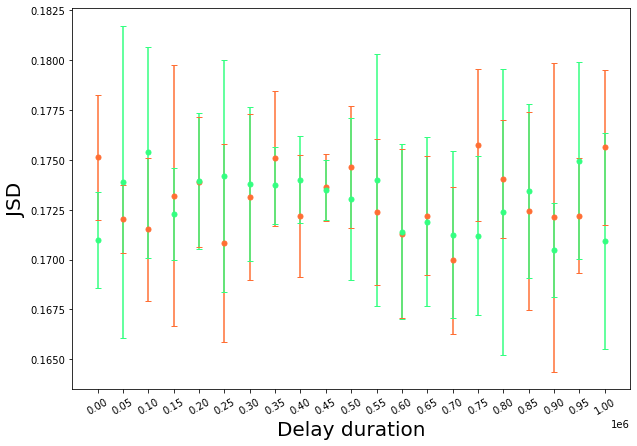

In [19]:
save_plot_path_e6 = _save_plot_path(date, "e6", initial_state, initial_layout)
plot_decay(e6, delay_duration_e6, save_plot_path_e6)

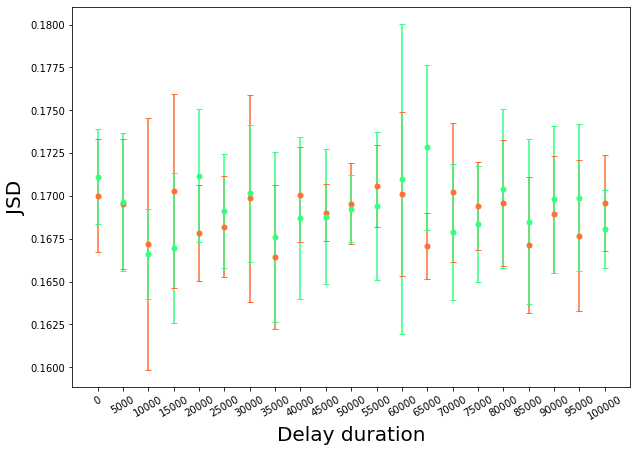

In [20]:
save_plot_path_e5 = _save_plot_path(date, "e5", initial_state, initial_layout)
plot_decay(e5, delay_duration_e5, save_plot_path_e5)

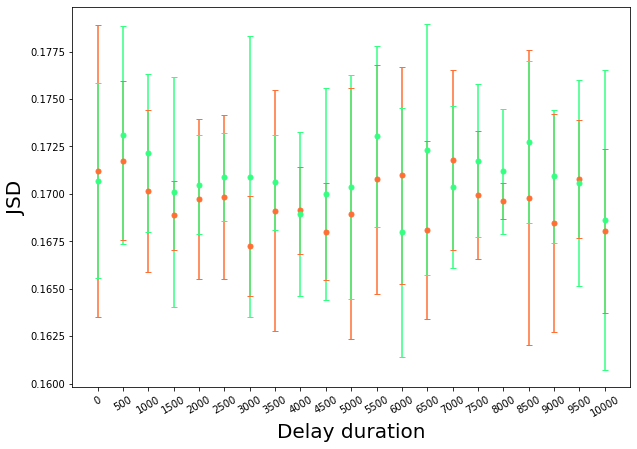

In [21]:
save_plot_path_e4 = _save_plot_path(date, "e4", initial_state, initial_layout)
plot_decay(e4, delay_duration_e4, save_plot_path_e4)